
# Demonstrate MNE-Python visualization @ OpenMR


From raw data to source reconstruction. <br>
For a more thorough and verbose introduction to (beamformer) source reconstruction see [the MNE-Python tutorial on beamforming](https://mne.tools/stable/auto_tutorials/source-modeling/plot_beamformer_lcmv.html).

In [1]:
# Author: Britta Westner <britta.wstnr@gmail.com>
# License: BSD (3-clause)

import matplotlib
import matplotlib.pyplot as plt

import mne
from mne.beamformer import make_lcmv, apply_lcmv
from mne.datasets import sample

In [2]:
%matplotlib qt  
mne.set_log_level('WARNING')  # do not show verbose output for live demonstration

## Read data and plot.raw()
We will use the `sample` public data set for this tutorial (MEG, EEG, and EOG data).


In [3]:
data_path = sample.data_path()  # downloads data automatically if not on disk yet
raw_fname = data_path + '/MEG/sample/sample_audvis_raw.fif'

# Read the raw data
raw = mne.io.read_raw_fif(raw_fname)

# We make a copy for plotting (only to not mess up live demonstration!)
raw_plot = raw.copy()

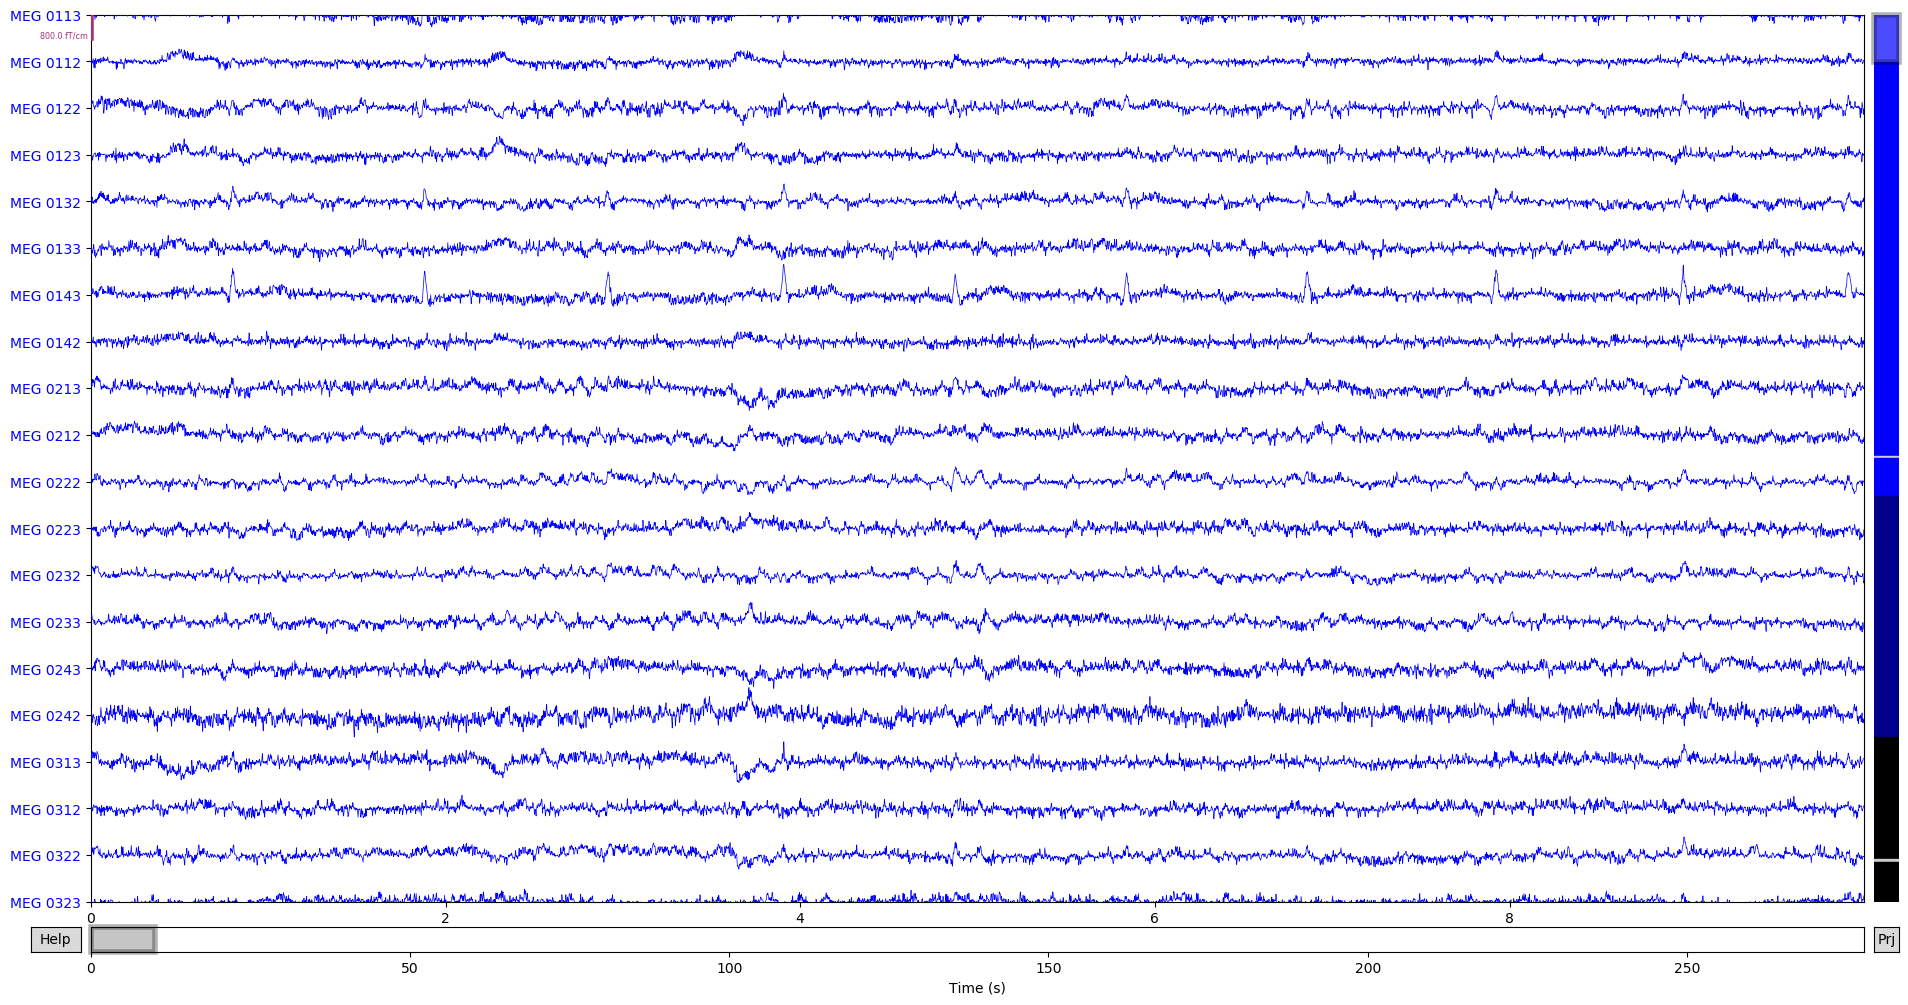

In [4]:
raw_plot.plot()

In [5]:
# look at the bad channels we added:
raw_plot.info

<Info | 21 non-empty values
 acq_pars: ACQch001 110113 ACQch002 110112 ACQch003 110111 ACQch004 110122 ...
 bads: 4 items (MEG 2443, EEG 053, EEG 034, EEG 043)
 ch_names: MEG 0113, MEG 0112, MEG 0111, MEG 0122, MEG 0123, MEG 0121, MEG ...
 chs: 204 GRAD, 102 MAG, 9 STIM, 60 EEG, 1 EOG
 custom_ref_applied: False
 description: acquisition (megacq) VectorView system at NMR-MGH
 dev_head_t: MEG device -> head transform
 dig: 146 items (3 Cardinal, 4 HPI, 61 EEG, 78 Extra)
 events: 1 item (list)
 experimenter: MEG
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 hpi_meas: 1 item (list)
 hpi_results: 1 item (list)
 lowpass: 172.2 Hz
 meas_date: 2002-12-03 19:01:10 UTC
 meas_id: 4 items (dict)
 nchan: 376
 proj_id: 1 item (ndarray)
 proj_name: test
 projs: PCA-v1: off, PCA-v2: off, PCA-v3: off
 sfreq: 600.6 Hz
>

In [6]:
# see the annotations we added:
raw_plot.annotations

<Annotations | 2 segments: BAD_blinks (2)>

## Create evoked

In [4]:
raw.info['bads'] = ['MEG 2443']  # bad MEG channel

# Set up the epoching
event_id = 1  # those are the trials with left-ear auditory stimuli
tmin, tmax = -0.2, 0.5
events = mne.find_events(raw)

# pick relevant channels
raw.pick(['meg', 'eog'])  # pick channels of interest

# Create epochs
proj = False  # already applied
epochs = mne.Epochs(raw, events, event_id, tmin, tmax,
                    baseline=(None, 0), preload=True, proj=proj,
                    reject=dict(grad=4000e-13, mag=4e-12, eog=150e-6))

# for speed purposes, we cut to a window of interest
evoked = epochs.average().crop(-0.1, 0.2)

## Plot evoked data

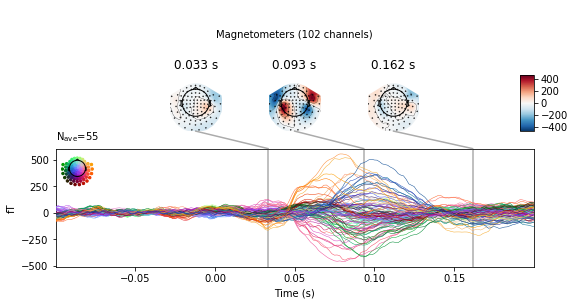

In [8]:
%matplotlib inline
# Visualize averaged sensor space data for magnetometers
evoked.plot_joint(picks=['mag']);

In [9]:
%matplotlib inline
from ipywidgets import interact

# create an interactive topoplot with interactive widgets:
@interact(time=(evoked.times[0], evoked.times[-1], 0.01), continuous_update=False)
def plot_topo(time):
    evoked.plot_topomap(ch_type='mag', times=[time], size=3.)

interactive(children=(FloatSlider(value=0.040102393420806084, description='time', max=0.19979521315838786, min…

## Prepare beamformer comptuation

In [5]:
# compute the datat covariance matrices
data_cov = mne.compute_covariance(epochs, tmin=0.01, tmax=tmax,
                                  method='empirical')
noise_cov = mne.compute_covariance(epochs, tmin=tmin, tmax=0,
                                   method='empirical')
# Read forward model
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
forward = mne.read_forward_solution(fwd_fname)

## Compute the beamformer spatial filter and apply it

Beamforming is one method to estimate the source activity that gave rise to the sensor data we recorded.

In [6]:
# compute the spatial filter:
filters = make_lcmv(evoked.info, forward, data_cov, reg=0.05,
                    noise_cov=noise_cov, pick_ori='max-power',
                    weight_norm='unit-noise-gain', rank=None)

# apply the spatial filter (= get source estimate):
stc = apply_lcmv(evoked, filters, max_ori_out='signed')

## Visualize the reconstructed source activity

In [9]:
%matplotlib qt

# find the maximum activity to initialize plot
vertno_max, time_max = stc.get_peak(hemi='rh')

# set up the plotting specifics and plot:
subjects_dir = data_path + '/subjects'
plot_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    views='lateral', clim=dict(kind='value', pos_lims=[0., 1., 1.85]),
    initial_time=time_max, time_unit='s', size=(600, 600), verbose=False)
brain = stc.plot(**plot_kwargs)